# <a id='toc1_'></a>[Automatizar reporte del IPC](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Automatizar reporte del IPC](#toc1_)    
  - [Uso del API del FMI para datos de República Dominicana: IPC](#toc1_1_)    
    - [Imports de las librerias que voy a utilizar](#toc1_1_1_)    
    - [Función para buscar el código del indicador deseado](#toc1_1_2_)    
    - [Función para buscar la estructura de datos](#toc1_1_3_)    
    - [Función para buscar los códigos de los indicadores](#toc1_1_4_)    
    - [Función para obtener el dataframe del IPC](#toc1_1_5_)    
    - [Función para obtener la variación del IPC](#toc1_1_6_)    
    - [Nota](#toc1_1_7_)    
      - [Actualización](#toc1_1_7_1_)    
  - [Usando el archivo de Excel del BCRD](#toc1_2_)    
    - [Imports adicionales](#toc1_2_1_)    
    - [Descarga de archivo](#toc1_2_2_)    
    - [Datos del reporte](#toc1_2_3_)    
    - [Hacer la data usable](#toc1_2_4_)    
    - [Gráfico de la inflación: ejemplo](#toc1_2_5_)    
    - [Indexar montos](#toc1_2_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Uso del API del FMI para datos de República Dominicana: IPC](#toc0_)

<div style="display: flex; align-items: center;;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Flag_of_the_Dominican_Republic.svg/1280px-Flag_of_the_Dominican_Republic.svg.png" alt="Bandera de República Dominicana" style="width: 150px; height: auto; margin-right: 10px;">
    <img src="https://bancentral.gov.do/bc_wp_template/img/logo-bc-footer.png" alt="Logo BCRD" style="width: 150px; height: auto; margin-right: 10px;">
    <div style="height: 150px; width: 2px; background-color: #000; margin: 0 10px;"></div> <!-- Vertical bar -->
    <img src="https://www.imf.org/assets/imf/images/footer/IMF_seal.svg" alt="Logo del FMI" style="width: 150px; height: auto;">
    <img src="https://sdmx.org/wp-content/uploads/sdmx-logo_2.png" alt="Logo del SDMX" style="width: 150px; height: auto;">
</div>

Las informaciones que necesites las puedes obtener en la página del Banco Central: <https://www.bancentral.gov.do/a/d/4158-national-summary-data-page-nsdp>

Pero, en caso que necesites utilizar la data constantemente, puede ser útil tenerla actualizable rápidamente. En mi caso, uso la tabla de excel del IPC del Banco Central constantemente y, por ende, voy a crear una herramienta que me permita automatizar mis procesos.

Fuentes:

- <https://datahelp.imf.org/knowledgebase/articles/667681-json-restful-web-service>
- <https://datahelp.imf.org/knowledgebase/articles/1968408-how-to-use-the-api-python-and-r>

### <a id='toc1_1_1_'></a>[Imports de las librerias que voy a utilizar](#toc0_)

In [1]:
import requests
from datetime import date
import polars as pl

In [2]:
# Configuración para poder ver 100 caracteres por columna
# y mostrar 30 filas
pl.Config(
    set_fmt_str_lengths = 100,
    set_tbl_rows = 30,
)

### <a id='toc1_1_2_'></a>[Función para buscar el código del indicador deseado](#toc0_)

In [3]:
def data_flow_search(search_term: str) -> None:
    """Función para buscar indicadores.
    
    Muestra los resultados de `database_id` 
    que coinciden con la búsqueda.

    Args:
        search_term (str): Palabras o siglas
        en inglés.
    """

    root_url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc'
    method = "DataFlow"
    url = f"{root_url}/{method}"

    result_list = (
        requests.get(url).json()
        ['Structure']['Dataflows']['Dataflow']
    )

    for item in result_list:
        if search_term.upper() in item['Name']['#text'].upper():
            name = item['Name']['#text']
            key_id = item['KeyFamilyRef']['KeyFamilyID']
            print(
                f"{name}: {key_id}"
            )

In [4]:
data_flow_search('cpi')

Consumer Price Index (CPI): CPI
Coordinated Portfolio Investment Survey (CPIS): CPIS


Según el resultado de la busqueda, debo utilizar el código `CPI`

### <a id='toc1_1_3_'></a>[Función para buscar la estructura de datos](#toc0_)

In [5]:
def data_structure_search(database_id: str) -> None:
    """Función para buscar las dimensiones, 
    es decir, los códigos que servirán para 
    solicitar el dataset que queremos.

    Args:
        database_id (str): código previamente 
        obtenido con la función `data_flow_search`.
    """
    
    root_url = "http://dataservices.imf.org/REST/SDMX_JSON.svc"
    method = "DataStructure"
    url = f"{root_url}/{method}/{database_id}"

    result_list = (
        requests.get(url).json()
        ['Structure']['KeyFamilies']['KeyFamily']
        ['Components']['Dimension']
    )

    for item in result_list:
        concept = item["@conceptRef"]
        concept_code = item["@codelist"]
        print(f"{concept}: {concept_code}")

In [6]:
data_structure_search("CPI")

FREQ: CL_FREQ
REF_AREA: CL_AREA_CPI
INDICATOR: CL_INDICATOR_CPI


Códigos de la Estructura:

- `CL_FREQ`: Frecuencia (M: Mensual, A: Anual)
- `CL_AREA_CPI`: País o Área (DO: República Dominicana)
- `CL_INDICATOR_CPI`: El tipo de IPC (general, alimentos, transporte, etc.) que buscaremos a continuación.

En este caso aparecieron estos 3 códigos, pero para otros indicadores distintos a `CPI` este resultado cambia.

### <a id='toc1_1_4_'></a>[Función para buscar los códigos de los indicadores](#toc0_)

In [7]:
def indicator_search(code: str) -> None:
    """Función para buscar la descripción de los  
    indicadores y su código.

    Args:
        code (str): código del indicador obtenido 
        con la función `data_structure_search`.
    """
    
    root_url = "http://dataservices.imf.org/REST/SDMX_JSON.svc"
    method = "CodeList"
    url = f"{root_url}/{method}/{code}"

    result_list = (
        requests.get(url).json()
        ['Structure']['CodeLists']['CodeList']['Code']
    )

    for item in result_list:
        code_description = item['Description']['#text']
        code = item['@value']
        print(f"{code}: {code_description}")

In [8]:
indicator_search("CL_INDICATOR_CPI")

PCPI_IX: Consumer Price Index, All items
PCPIF_IX: Food and non-alcoholic beverages
PCPIFBT_IX: Alcoholic Beverages, Tobacco, and Narcotics
PCPIA_IX: Clothing and footwear
PCPIH_IX: Housing, Water, Electricity, Gas and Other Fuels
PCPIHO_IX: Furnishings, household equipment and routine household maintenance
PCPIM_IX: Health
PCPIT_IX: Transport
PCPIEC_IX: Communication
PCPIR_IX: Recreation and culture
PCPIED_IX: Education
PCPIRE_IX: Restaurants and hotels
PCPIO_IX: Miscellaneous goods and services
PCPI_OLP_IX: Consumer Price Index, All items, Overlap
PCPIF_OLP_IX: Food and non-alcoholic beverages, Overlap
PCPIFBT_OLP_IX: Alcoholic Beverages, Tobacco, and Narcotics, Overlap
PCPIA_OLP_IX: Clothing and footwear, Overlap
PCPIH_OLP_IX: Housing, Water, Electricity, Gas and Other Fuels, Overlap
PCPIHO_OLP_IX: Furnishings, household equipment and routine household maintenance, Overlap
PCPIM_OLP_IX: Health, Overlap
PCPIT_OLP_IX: Transport, Overlap
PCPIEC_OLP_IX: Communication, Overlap
PCPIR_OLP_

La busqueda nos muestra todos los indicadores disponibles. Aunque, probablemente no todos esten incluidos en las estadisticas recurrentes, y por ende, no arrojen resultados si se intenta hacer la consulta.

En este caso voy a usar el IPC general: `PCPI_IX`

### <a id='toc1_1_5_'></a>[Función para obtener el dataframe del IPC](#toc0_)

In [9]:
def get_cpi(
    database_id: str,
    frequency: str,
    ref_area: str,
    indicator: str
) -> pl.DataFrame:

    """Función que genera un dataframe con los valores del IPC.

    Returns:
        polars.DataFrame
    """
    
    root_url = "http://dataservices.imf.org/REST/SDMX_JSON.svc"
    method = "CompactData"

    # Se podría incluir un filtro de fechas segun la documentación del API
    # Pero para este caso prefiero tener todas las fechas
    url = f"{root_url}/{method}/{database_id}/{frequency}.{ref_area}.{indicator}"

    data = (
            requests.get(url).json()
            ['CompactData']['DataSet']['Series']
    )

    obs_list_of_dicts = data['Obs']

    reference_period = [obs.get("@REFERENCE_PERIOD") for obs in obs_list_of_dicts]
    time_period = [obs.get("@TIME_PERIOD") for obs in obs_list_of_dicts]
    obs_value = [obs.get("@OBS_VALUE") for obs in obs_list_of_dicts]

    df = (
        pl.DataFrame(data)
        .drop('Obs')
        .unique()
        .join(
            pl.DataFrame(
                {
                    "REFERENCE_PERIOD":reference_period,
                    "TIME_PERIOD": time_period,
                    "OBS_VALUE": obs_value
                }
            ),
            how="cross"
        )
        .drop_nulls()
        .with_columns(
            pl.col("TIME_PERIOD").str.to_date("%Y-%m"),
            pl.col("OBS_VALUE").cast(pl.Float64)
        )
    )

    return df

In [10]:
# Pasamos los argumentos
cpi_df = get_cpi(
    database_id = "CPI",
    frequency = "M",
    ref_area = "DO",
    indicator = "PCPI_IX",
)

In [11]:
cpi_df.shape

(301, 9)

In [12]:
cpi_df.describe()

statistic,@FREQ,@REF_AREA,@INDICATOR,@UNIT_MULT,@COMMON_REFERENCE_PERIOD,@TIME_FORMAT,REFERENCE_PERIOD,TIME_PERIOD,OBS_VALUE
str,str,str,str,str,str,str,str,str,f64
"""count""","""301""","""301""","""301""","""301""","""301""","""301""","""301""","""301""",301.0
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0
"""mean""",null,null,null,null,null,null,null,"""2011-07-02""",72.632649
"""std""",null,null,null,null,null,null,null,null,29.409746
"""min""","""M""","""DO""","""PCPI_IX""","""0""","""2019M10-2020M09""","""P1M""","""2019M10-2020M09""","""1999-01-01""",21.361336
"""25%""",null,null,null,null,null,null,null,"""2005-04-01""",53.270447
"""50%""",null,null,null,null,null,null,null,"""2011-07-01""",78.566192
"""75%""",null,null,null,null,null,null,null,"""2017-10-01""",92.697032
"""max""","""M""","""DO""","""PCPI_IX""","""0""","""2019M10-2020M09""","""P1M""","""2019M10-2020M09""","""2024-01-01""",126.9796


Podemos ver que la fecha mínima es enero de 1999. En el Excel del BCRD está desde 1984, y acá esa fecha fue descartada porque tiene valor nulo.

A lo mejor se debe a que el IPC por Grupos de Bienes y Servicios está desde el 1999 también.

In [13]:
# Ejemplo de la data generada:
(
    cpi_df
    .sort(by="TIME_PERIOD", descending=True)
    .head()
)

@FREQ,@REF_AREA,@INDICATOR,@UNIT_MULT,@COMMON_REFERENCE_PERIOD,@TIME_FORMAT,REFERENCE_PERIOD,TIME_PERIOD,OBS_VALUE
str,str,str,str,str,str,str,date,f64
"""M""","""DO""","""PCPI_IX""","""0""","""2019M10-2020M09""","""P1M""","""2019M10-2020M09""",2024-01-01,126.9796
"""M""","""DO""","""PCPI_IX""","""0""","""2019M10-2020M09""","""P1M""","""2019M10-2020M09""",2023-12-01,126.4866
"""M""","""DO""","""PCPI_IX""","""0""","""2019M10-2020M09""","""P1M""","""2019M10-2020M09""",2023-11-01,125.8094
"""M""","""DO""","""PCPI_IX""","""0""","""2019M10-2020M09""","""P1M""","""2019M10-2020M09""",2023-10-01,125.6376
"""M""","""DO""","""PCPI_IX""","""0""","""2019M10-2020M09""","""P1M""","""2019M10-2020M09""",2023-09-01,125.3654


### <a id='toc1_1_6_'></a>[Función para obtener la variación del IPC](#toc0_)

In [14]:
def cpi_change(
    df: pl.DataFrame,
    start_year_month: int,
    end_year_month: int
) -> float:

    """Función para calcular el porcentaje de variación del IPC \
a partir del dataframe generado por `get_cpi`.

    Raises:
        ValueError: Cuando el formato de las fechas es incorrecto. \
También cuando se intenta con fechas no disponibles.
    """

    if not isinstance(df, pl.DataFrame):
        raise TypeError("""No es un polars dataframe.""")

    if (
        len(str(start_year_month))
        & len(str(end_year_month)) != 6
    ) & (
        isinstance(start_year_month, int)
        & isinstance(end_year_month, int)
    ):
        raise ValueError(
            """`start_year_month` y `end_year_month` \
deben ser números enteros en formato YYYYMM. \
Por ejemplo: 201501
            """
        )

    start_year = int(str(start_year_month)[:4])
    start_month = int(str(start_year_month)[5:])

    end_year = int(str(end_year_month)[:4])
    end_month = int(str(end_year_month)[5:])

    start_date = date(start_year, start_month, 1)
    end_date = date(end_year, end_month, 1)

    min_date = min(df['TIME_PERIOD'].to_list())
    max_date = max(df['TIME_PERIOD'].to_list())

    if (start_date >= min_date) & (end_date <= max_date):
        pass
    else:
        raise ValueError("""No hay data disponible para el rango de fechas.""")

    start_cpi = (
        df
        .filter(
            pl.col("TIME_PERIOD") == start_date
        )['OBS_VALUE'][0]
    )

    end_cpi = (
        df
        .filter(
            pl.col("TIME_PERIOD") == end_date
        )['OBS_VALUE'][0]
    )

    pct_change = end_cpi / start_cpi - 1

    return pct_change

In [15]:
cpi_change(cpi_df, 201401, 202401)

0.4799336621402088

En este ejemplo, la variación del IPC desde enero 2014 a enero 2024 ha sido de prácticamente 48%.

### <a id='toc1_1_7_'></a>[Nota](#toc0_)

Verificando, veo que al día de hoy 2024-03-07 el IPC de febrero 2024 acaba de ser actualizado en los archivos de Excel del BCRD. Como veo que el API aun no registra los cambios, probablemente el proceso sea primero generarlo en Excel y luego enviar la data al SDMX.

En ese caso, si el tiempo es un factor, se podría automatizar la descarga del archivo y leer el contenido. Eso si, el formato que traen esos archivos no es directamente amigable, por ende, hay que ejecutar algunas modificaciones. Es una solución menos elegante, pero funciona:

#### <a id='toc1_1_7_1_'></a>[Actualización](#toc0_)

Dos días despues de que se publicara el IPC en Excel en la web del BCRD, la data del SDMX del BCRD fue actualizada, es decir, el 2024-03-09.

Pero todavía no en el API del FMI.

## <a id='toc1_2_'></a>[Usando el archivo de Excel del BCRD](#toc0_)

### <a id='toc1_2_1_'></a>[Import adicional](#toc0_)

In [16]:
import polars.selectors as cs

### <a id='toc1_2_2_'></a>[Descarga de archivo](#toc0_)

In [17]:
url = "https://cdn.bancentral.gov.do/documents/estadisticas/\
precios/documents/ipc_base_2019-2020.xls?v=1687458753373"

file_extension = ".xls"

r = requests.get(url)

filename = f"{url.split(file_extension)[0].split("/")[-1]}\
{file_extension}"

with open(filename, 'wb') as f:
    f.write(r.content)

### <a id='toc1_2_3_'></a>[Datos del reporte](#toc0_)

In [18]:
df = pl.read_excel(filename)

report_title_info = df.columns[0]
report_type_info = df[0,0]
report_base_info = df[1,0]

# DAtos
print(
    '\n'
    ,report_title_info,
    '\n',
    report_type_info,
    '\n',
    report_base_info
)


 Indice de Precios al Consumidor Nacional, Serie Mensual, 1984-2024 
 Serie Empalmada Oficial 
 Base Anual: Octubre 2019 - Septiembre 2020=100


### <a id='toc1_2_4_'></a>[Hacer la data usable](#toc0_)

In [19]:
# Delimitar el dataframe al espacio 'usable'
df = df[4:-1, :-3]

# Renombrar las columnas
df.columns = [
    'Año',
    'Mes',
    'Indice',
    'Variación Porcentual Mensual',
    'Variación Porcentual con Diciembre',
    'Variación Porcentual 12 meses',
    'Promedio 12 meses'
]

In [20]:
# Modificaciones de datos y de formato
df = (
    df
    .with_columns(
        # Por algún motivo el método strip_chars no reemplaza
        # algunas celdas con espacios debajo de 1996.
        # Se reemplaza las celdas de 0 bytes que no son nulas
        pl.when(
            pl.col('Año').str.len_bytes() == 0
        )
        .then(None)
        .otherwise(pl.col('Año'))
        .alias('Año')
    )
)

df = (
    df
    .with_columns(
        pl.col('Año')
        # Eliminar espacios en blanco
        .str.strip_chars()

        # Convetir de string a float
        .cast(pl.Int64, strict=False)

        # Completar los valores nulos
        .fill_null(strategy="forward"),

        # Convertir de string a float las columnas
        # que contienen estas palabras
        (cs.contains(("Indice","Variación","Promedio")))
        .cast(pl.Float64),

        # Eliminar espacios en blanco - Mes
        pl.col('Mes')
        .str.strip_chars()
    )
    # Eliminar cualquier fila en blanco convertida en null
    .drop_nulls()    
)

In [21]:
# Otras modificaciones

df = (
    # Traer los meses en números
    df
    .join(
        pl.DataFrame(
            {
                'Mes': [
                    'Enero',
                    'Febrero',
                    'Marzo',
                    'Abril',
                    'Mayo',
                    'Junio',
                    'Julio',
                    'Agosto',
                    'Septiembre',
                    'Octubre',
                    'Noviembre',
                    'Diciembre'
                ],
                'mes_num': range(1,13)
            }
        ),
        on = 'Mes',
        how='left'
    )
    .with_columns(
        pl.date('Año', 'mes_num', 1)
        .alias('TIME_PERIOD')
    )
    # Solo uso estas 2 columnas
    # Si deseas utilizarlas todas elimina el select y el rename
    # Para las 2 columnas uso el mismo nombre que tienen en el API del FMI
    .select(['TIME_PERIOD', 'Indice'])
    .rename({'Indice':'OBS_VALUE'})
)

In [22]:
df.describe()

statistic,TIME_PERIOD,OBS_VALUE
str,str,f64
"""count""","""482""",482.0
"""null_count""","""0""",0.0
"""mean""","""2004-01-15""",49.107856
"""std""",null,38.409326
"""min""","""1984-01-01""",1.37936
"""25%""","""1994-01-01""",13.95858
"""50%""","""2004-02-01""",48.163687
"""75%""","""2014-02-01""",86.095266
"""max""","""2024-02-01""",127.0946


In [23]:
df.head()

TIME_PERIOD,OBS_VALUE
date,f64
1984-01-01,1.37936
1984-02-01,1.418138
1984-03-01,1.435622
1984-04-01,1.458127
1984-05-01,1.475611


In [24]:
cpi_change(df, 198401,202402)

91.14024383106026

Ahora tenemos los datos del IPC general desde el 1984, además de que se actualizó primero que el API 😃

### <a id='toc1_2_5_'></a>[Gráfico de la inflación: ejemplo](#toc0_)

In [25]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

In [26]:
df_inflacion = (
    df
    .with_columns(
        pl.col("OBS_VALUE")
        .pct_change()
        .alias("pct_change")
    )
)

In [27]:
df_inflacion.head()

TIME_PERIOD,OBS_VALUE,pct_change
date,f64,f64
1984-01-01,1.37936,null
1984-02-01,1.418138,0.028112
1984-03-01,1.435622,0.012329
1984-04-01,1.458127,0.015676
1984-05-01,1.475611,0.011991


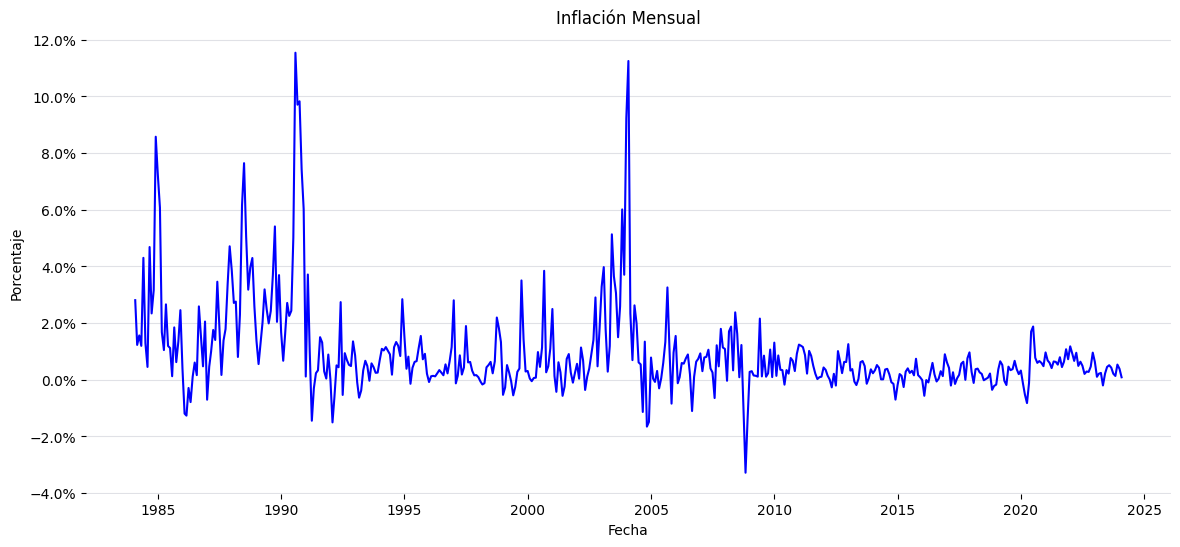

In [28]:
fig, ax = plt.subplots(figsize=(14,6))

ax.grid(axis='y', color='#E0E1E6')
ax.set_frame_on(False)

ax.plot(
    df_inflacion['TIME_PERIOD'],
    df_inflacion['pct_change'],
    color = 'blue'
)

ax.set(
    title = 'Inflación Mensual',
    xlabel = 'Fecha',
    ylabel = 'Porcentaje'
)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

### <a id='toc1_2_6_'></a>[Indexar montos](#toc0_)

In [29]:
import random
from datetime import datetime, timedelta

In [30]:
random.seed(42)

In [31]:
# Formula para generar fechas aleatorias
def generate_random_date(start_date, end_date, random_seed):

    start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date = datetime.strptime(end_date, '%Y-%m-%d').date()

    # Set the random seed for consistency
    random.seed(random_seed)

    delta = (end_date - start_date).days

    all_dates = [start_date + timedelta(days=i) for i in range(delta + 1)]

    random.shuffle(all_dates)

    return all_dates

In [32]:
# Fechas aleatorias dentro del rango
start_date = '1984-01-01'
end_date = '2024-02-01'

random_dates = generate_random_date(start_date, end_date, random_seed=42)

date_list = []
for x in range(10):
    date_list.append(random_dates[x])

In [33]:
# Montos aletorios
amount_list = []

random.seed(42)

for x in range(10):
    r_num = random.randint(1000,100000)
    amount_list.append(r_num)

In [34]:
# Dataframe para ejemplo
some_df = pl.DataFrame(
    {
        'fecha': date_list,
        'monto': amount_list
    }
)

In [35]:
(
    some_df
    .sort(by='fecha')

    #traemos el índice del año-mes de la columna fecha
    .join_asof(
        df.sort(by='TIME_PERIOD'),
        left_on='fecha',
        right_on='TIME_PERIOD',
        strategy='backward'
    )

    # traemos el índice de referencia
    # por ejemplo, el último año-mes registrado
    # de ser otro deberiamos pasar el año-mes deseado
    # o pasar una lista de fechas segun la necesidad
    .join(
        df
        .filter(
            pl.col('TIME_PERIOD') == pl.max('TIME_PERIOD')
        ),
        how="cross",
        suffix="_referencia"
    )

    # cálculamos el factor de cambio
    .with_columns(
        (pl.col('OBS_VALUE_referencia') / pl.col('OBS_VALUE'))
        .alias('factor')
    )

    # por último obtenemos el monto indexado
    .with_columns(
        (pl.col('monto') * pl.col('factor'))
        .alias('monto_indexado')
    )
)

fecha,monto,TIME_PERIOD,OBS_VALUE,TIME_PERIOD_referencia,OBS_VALUE_referencia,factor,monto_indexado
date,i64,date,f64,date,f64,f64,f64
1985-02-22,4278,1985-02-01,2.138112,2024-02-01,127.0946,59.442431,254294.718975
1989-08-11,15592,1989-08-01,5.710116,2024-02-01,127.0946,22.257798,347043.584438
1990-08-07,19289,1990-08-01,8.658914,2024-02-01,127.0946,14.677892,283121.852193
1994-03-20,33098,1994-03-01,14.257545,2024-02-01,127.0946,8.914199,295042.171846
1996-06-15,37048,1996-06-01,17.459607,2024-02-01,127.0946,7.279351,269685.380802
1996-11-09,14434,1996-11-01,17.784366,2024-02-01,127.0946,7.146423,103151.468007
2006-09-20,30256,2006-09-01,56.715062,2024-02-01,127.0946,2.240932,67801.64
2009-02-14,84810,2009-02-01,65.885314,2024-02-01,127.0946,1.929028,163600.844114
2012-04-21,97530,2012-04-01,80.060207,2024-02-01,127.0946,1.587488,154827.682511
